<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2019-07-08 06:45:33--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2019-07-08 06:45:33 (98.4 MB/s) - ‘shampoo.csv’ saved [519/519]



In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2019-07-08 06:45:38--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2019-07-08 06:45:38 (37.8 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import pickle
from sklearn.preprocessing import MinMaxScaler

## Hyperparameters

In [ ]:

# data
seq_length = 4
feature_range = (0, 1)

# model
num_epochs = 2000
learning_rate = 0.01
input_size = 1
hidden_size = 2
num_layers = 1
num_future_steps = 1

#general
random_seed = 2023
device = "cuda"
epoch = 10
batch_size = 64

## Data Plot

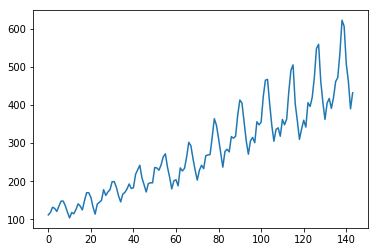

In [289]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Shampoo Sales Data')
plt.show()

## Dataloading

In [ ]:
def sliding_windows(data_X, data_Y, look_back, look_forward, stride = 1):
    '''
    data_X: input data, a dictionary of (machine_id, numpy array of shape (num_dates, len_feature_vector))
    data_Y: output data, a dictionary of (machine_id, python_list of length num_dates)
    look
    type: can be "AR" or "encoder_decoder"
    '''

    x = []
    y = []

    assert len(data_X)  == len(data_Y), "The length of data_X and data_Y must be equal"
    assert set(data_X.keys()) == set(data_Y.keys()), "The keys of data_X and data_Y must be equal"

    for key, feature_vector_list in data_X.items():
        for i in range(0, len(feature_vector_list)-look_back-look_forward+1, stride):
            _x = feature_vector_list[i : (i+look_back)]
            _y = data_Y[key][i+look_back : (i+look_back+look_forward)]
            x.append(_x)
            y.append(_y)

    return np.array(x),np.array(y)

with open('data_X', 'rb') as f:
    data_X = pickle.load(f)

    
x, y = sliding_windows(training_data, training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

## Model

In [ ]:
class LSTM(nn.Module):

    def __init__(
        self, 
        num_future_steps, 
        input_size,
        hidden_size, 
        num_layers, 
        num_machine = 2000, 
        num_event = 300, 
        num_incident = 300,
        num_ville = 300, 
        embedding_size = 10,
        seq_length = 10,
        bi_directional = False,
        device = 'cpu'
        ):
        super(LSTM, self).__init__()
        
        ## create nn.embedding for each categorical variable
        self.machine_embedding = nn.Embedding(num_machine, embedding_size)
        self.event_embedding = nn.Embedding(num_event, embedding_size)
        self.incident_embedding = nn.Embedding(num_incident, embedding_size)
        self.ville_embedding = nn.Embedding(num_ville, embedding_size)

        self.num_future_steps = num_future_steps
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.device = device
        self.bi_directional = bi_directional


        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=bi_directional)
        
        self.fc = nn.Linear(hidden_size, num_future_steps)

    def forward(self, x):
        # x is a numpy array of shape (batch_size, seq_length, input_size)
        # first 4 columns of 3th dimension are categorical variables 
        # with the following format:
        # 1. machine index:  a number
        # 2. event index: a list of numbers
        # 3. incident index: a list of numbers
        # 4. ville index: a number

        # ============== generate final inputs ==============

        # retrieve embedding for each categorical variable
        machine_embedding = self.machine_embedding(x[:,:,0].long())
        # for event, we do an average of the embedding of the list of numbers
        event_embedding = self.event_embedding(x[:,:,1].long())
        event_embedding = torch.mean(event_embedding, dim=2)
        # for type_incidents, we do an average of the embedding of the list of numbers
        incident_embedding = self.incident_embedding(x[:,:,2].long())
        incident_embedding = torch.mean(incident_embedding, dim=2)
        # ville
        ville_embedding = self.ville_embedding(x[:,:,3].long())

        # concatenate all embeddings with the rest of x and convert to tensor
        x = torch.cat(( machine_embedding, event_embedding, incident_embedding, ville_embedding, x[:,:,4:]), dim=2)
        # to device
        x = x.to(self.device)

        # ============== generate final inputs ==============

        # ============== LSTM ==============
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # h_out.size() = (#layers*D, batch_size, hidden_size) 
        # for each batch, take the hidden state of the last layer
        h_out = h_out[-1, :, :]
        h_out = h_out.squeeze() 
        # h_out.size() = (batch_size, hidden_size)
        logits = self.fc(h_out)
        # ============== LSTM ==============
        
        return logits

## Training

In [332]:
# set the random seed manually for reproducibility.
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)    
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lstm = LSTM(num_future_steps, input_size, hidden_size, num_layers).to(device)
lstm.train()
criterion = torch.nn.BCEWithLogitsLoss( reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # adam optimizer with betas set to default values


# Train the model
for epoch in range(num_epochs):
    lstm.train() 
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.86919
Epoch: 100, loss: 0.01413
Epoch: 200, loss: 0.00797
Epoch: 300, loss: 0.00321
Epoch: 400, loss: 0.00290
Epoch: 500, loss: 0.00277
Epoch: 600, loss: 0.00263
Epoch: 700, loss: 0.00249
Epoch: 800, loss: 0.00236
Epoch: 900, loss: 0.00224
Epoch: 1000, loss: 0.00213
Epoch: 1100, loss: 0.00204
Epoch: 1200, loss: 0.00197
Epoch: 1300, loss: 0.00191
Epoch: 1400, loss: 0.00186
Epoch: 1500, loss: 0.00182
Epoch: 1600, loss: 0.00179
Epoch: 1700, loss: 0.00176
Epoch: 1800, loss: 0.00173
Epoch: 1900, loss: 0.00172


## Testing for Shampoo Sales Dataset

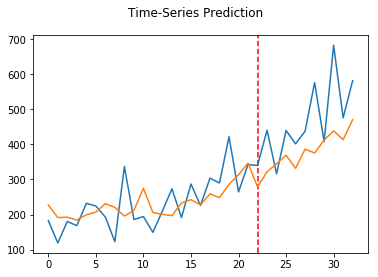

In [281]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Testing for Airplane Passengers Dataset

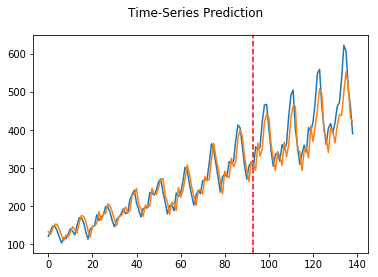

In [333]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()